In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
from AxionClass_new import SolarAxion
import blueice as ebi

/home/ershockley/blueice/blueice/inference.py:27: UserWarning: You don't have iminuit installed; switching to scipy minimizers.We've had several issues with these on degenerate problems, you're advised to do conda install -c astropy iminuit
  warnings.warn("You don't have iminuit installed; switching to scipy minimizers."


### Read in $\sigma_{pe}$ data ###

In [3]:
xsec_data = pd.read_csv('/home/ershockley/analysis/axions/data/photoelectric_xsecs.csv',
                        header=0, names=["energy", "xsec"])
pe_xsec = interp1d(xsec_data['energy'], xsec_data['xsec'], bounds_error=False, fill_value=0.0)

### Define function for $\sigma_{ae}$ ###

In [4]:
m_e = 511
alpha = 1/137
A = 131.3

def axion_xsec(E, m, g):
    ''' returns cross section in units of barns'''
    beta = np.sqrt(E**2 - m**2) / E
    if hasattr(E, 'shape'):
        E = E*(E >= m) 
        return np.nan_to_num((pe_xsec(E) * (g**2)/beta * 3*(E**2)/(16*np.pi*alpha*m_e**2) * (1 - beta**(2/3)/3)) 
                             * (E >= m))
    else:
        if E < m:
            return 0    
        return pe_xsec(E) * (g**2)/beta * 3*(E**2)/(16*np.pi*alpha*m_e**2) * (1 - beta**(2/3)/3) 


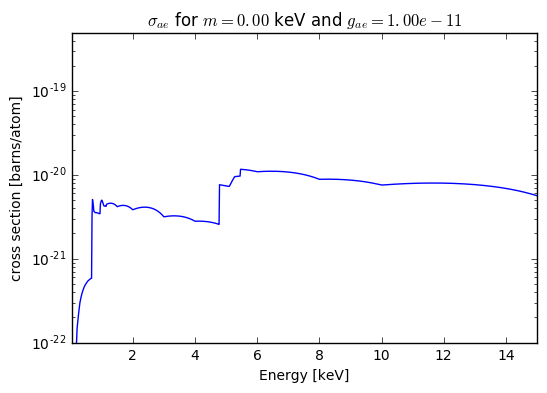

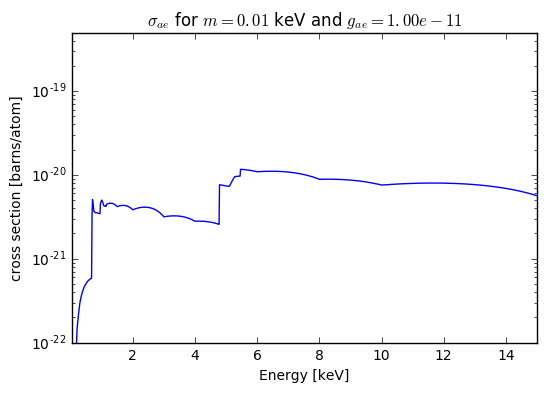

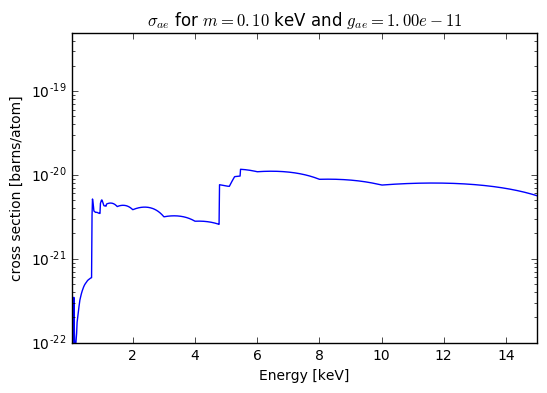

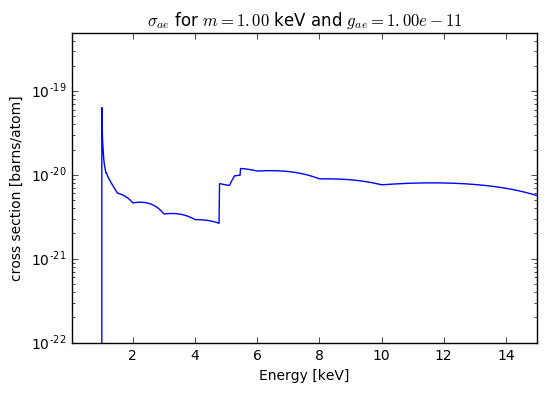

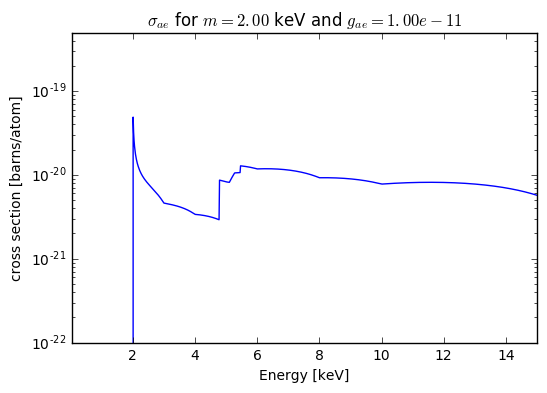

In [40]:
def plot_sigAe(m, g):
    plt.figure(figsize=(6,4))
    Es = np.linspace(0, 15, 1000)
    plt.plot(Es, axion_xsec(Es, m, g))
    plt.yscale('log')
    #plt.xscale('log')
    plt.xlim(5e-2,15)
    plt.ylim(1e-22, 5e-19)
    plt.title("$\sigma_{ae}$ for $m=%0.2f$ keV and $g_{ae}=%0.2e$" % (m, g))
    plt.ylabel("cross section [barns/atom]")
    plt.xlabel("Energy [keV]")

for m in [0, 0.01, 0.1, 1, 2]:
    plot_sigAe(m, 1e-11)
    if m==0:
        plt.savefig('axioelectric_sigma.png')
    plt.show()

### Read in solar axion flux values ### 
taken from https://arxiv.org/abs/1310.0823v1

In [14]:
Es = []
fluxes = []
with open("data/gaeflux.dat") as f:
    start_data = False
    for i, line in enumerate(f.readlines()):
        if not start_data:
            if line.startswith("##"):
                start_data = True
        else:
            ll = line.rstrip().split("\t")
            Es.append(float(ll[0]))
            fluxes.append(float(ll[1])*1e19)
flux_interp= interp1d(Es, fluxes)            

### Define solar axion flux and energy spectrum functions ###

In [15]:
gscale = 0.511e-10 # don't change
N_a = 6.022e23
A = 131.3/1e3 # kg/mol

def solarflux(Es, g):
    ''' returns solar flux in units of axions per cm^2 per day'''
    return flux_interp(Es) * (g/gscale)**2

def solarflux_lux(Es, g):
    ''' returns solar flux in units of axions per cm^2 per day'''
    return flux_interp(Es) * (g/gscale)**2

def spectrum(E, m, g):
    return (N_a/A) * axion_xsec(E, m, g) * solarflux(E, g) * 1e-24

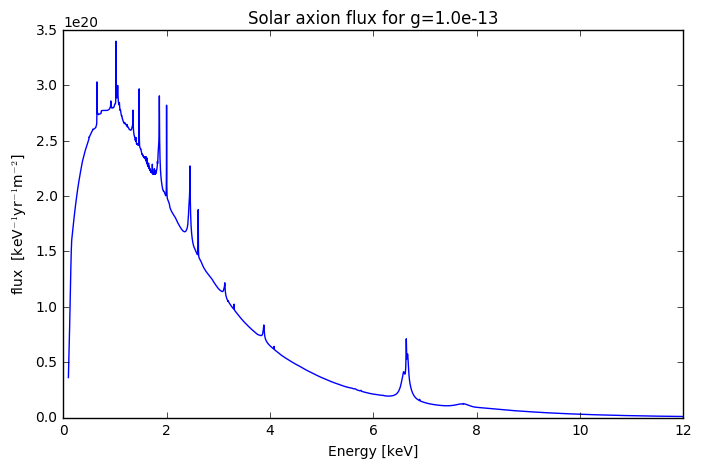

In [38]:
g = 1e-13
F = solarflux(Es, g) * 1e4 *365
plt.figure(figsize=(8,5))
plt.plot(Es, F)
plt.title("Solar axion flux for g=%0.1e" % g)
plt.xlabel("Energy [keV]")
plt.ylabel('flux  [keV$^{-1}$yr$^{-1}$m$^{-2}$]')
plt.savefig('solaraxion_flux.pdf')
plt.savefig('solaraxion_flux.png')
plt.show()

In [27]:
m =0 #keV
g = 1e-12
Espectrum_massless = np.array([spectrum(E, m, g) for E in Es])

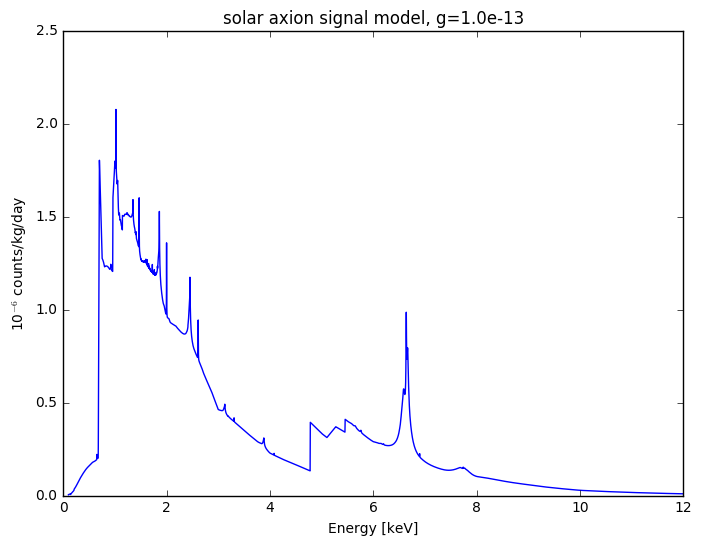

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(Es, Espectrum_massless*1e6)
plt.xlabel("Energy [keV]")
plt.ylabel("10$^{-6}$ counts/kg/day")
plt.title("solar axion signal model, g=%0.1e" % g)
plt.savefig('solaraxion_Espectrum.pdf')
plt.savefig('solaraxion_Espectrum.png')
plt.show()

In [29]:
I = 0
for i, (E, rate) in enumerate(zip(Es,Espectrum)):
    if i>0:
        I += rate * (E-Es[i-1])
print(I*95*118)

0.0466010049543


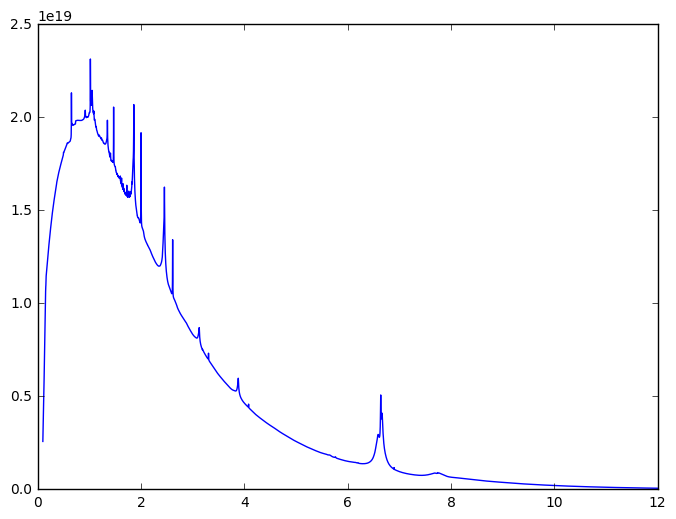

In [30]:
newEs = np.linspace(Es[0], Es[-1], 10000)

plt.plot(newEs, flux_interp(newEs))
plt.show()

with open("data/solaraxion_flux.csv", "w") as f:
    f.write(",E,flux\n")
    for i, (E, F) in enumerate(zip(newEs, flux_interp(newEs))):
        f.write("%d,%e,%e\n" % (i, E, F))

In [31]:
from AxionClass_new import SolarAxion
import blueice as bi

s = SolarAxion(5, g=1e-11)

11.9983581316


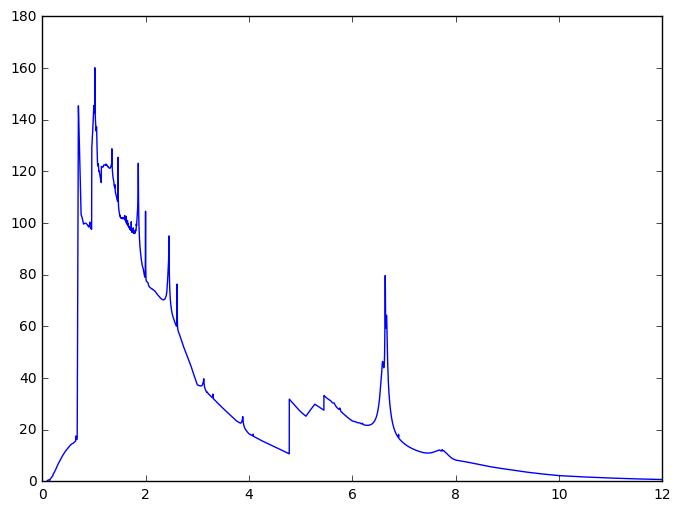

In [32]:
# read in spectrum
s = SolarAxion(1e-3, g=3e-12)
data = pd.read_csv('solar_axion.csv')

E = data['E']
spectrum = data['energy_spectrum']

plt.plot(E, spectrum*1e6)

expected_events = np.sum(spectrum) * (E[1]-E[0])
print(expected_events * 1042 * 34.2)

In [37]:
g = 1e-12
s = SolarAxion(1e-3, g=g)
lf = bi.UnbinnedLogLikelihood(s.config)
lf.add_rate_parameter('solar_axion')
lf.add_rate_parameter('erbkg')
lf.prepare()

In [ ]:
from scipy import stats
minimize_kwargs = {'method' : "Powell", "options" : {'maxiter' : 10000000}}

rms = [1, 1e1, 1e2, 1e3]

for i, rm in enumerate(rms):
    d = lf.base_model.simulate({'solar_axion' : rm})
    lf.set_data(d)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
    
    plt.sca(ax1)
    lf.base_model.show(d)
    plt.legend(fontsize='large', loc='upper left')
    print(len(d))
    plt.sca(ax2)
    lim = bi.inference.one_parameter_interval(lf, 'solar_axion_rate_multiplier', 
                                              1e4, bestfit_routine=bi.inference.bestfit_scipy,
                                              minimize_kwargs=minimize_kwargs)
    
    #print(lim, "  ", (lim**0.25)*g)
    
    bi.inference.plot_likelihood_ratio(lf,
                                       ('solar_axion_rate_multiplier', 
                                        np.logspace(-5, 5, 500))
                                      )
    plt.axvline(lim, color='black', linewidth=1)
    plt.axhline(0.5*stats.norm.ppf(0.9)**2, color='black', linewidth=1)
    plt.xscale('log')
    plt.savefig('plots/solarsim_%d.pdf' % i)
    plt.show()

In [ ]:
sr0 = pd.read_csv('/project/lgrandi/tunnell/data/sciencerun0/pax_6.4.2/lax_0.11.1/data_none_lowenergy_roi.csv')

sr0['cs2'] = sr0['cs2_new']

lf.set_data(sr0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

plt.sca(ax1)
plt.scatter(sr0['cs1'], sr0['cs2'])

plt.legend(fontsize='large', loc='upper left')

plt.sca(ax2)
lim = bi.inference.one_parameter_interval(lf, 'solar_axion_rate_multiplier', 
                                          1e4, bestfit_routine=bi.inference.bestfit_scipy,
                                          minimize_kwargs=minimize_kwargs)

print(lim, "  ", (lim**0.25)*g)

bi.inference.plot_likelihood_ratio(lf,
                                   ('solar_axion_rate_multiplier', 
                                    np.logspace(-5, 5, 500))
                                  )
plt.axvline(lim, color='black', linewidth=1)
plt.axhline(0.5*stats.norm.ppf(0.9)**2, color='black', linewidth=1)
plt.xscale('log')
